<img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width="80%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2021 </h1>

<H3 align='center'> Tema 10 - Ejemplos Prácticos </H3>

----

<H3 align='center'> <b>Profesores: Ricardo Ñanculef, Carlos Valle </b> </H3>
<H3 align='center'> <b>Ayudantes: Álvaro Fuentes,Miguel Huerta </b> </H3>



<hr style="height:2px;border:none"/>


# Introducción

En este taller de ejemplos prácticos nos centraremos en Mecanismo de Atención revisando un problema de Captioning. Un problema de Image Captitioning esta en la intersección de Computer Vision y Natural Language Processing (NLP): dada una imagen, el modelo debe generar un caption (subtítulo) que sea sensible, exacto y gramáticalmente correcto [1]. 

Trabajaremos sobre el dataset Flickr8k y un mecanismo de atención BahdanauAttention. Finalmente se mapearan los pesos atencionales al input para visualizar cómo la red toma decisiones.

**Nota:** este notebook código demora bastante en ejecutar.

[1] Sharma L. & Tan E. (2019) - Neural Image Captioning.



# Librerías

Como ya es usual utilizaremos Python y su ecosistema básico para data science y machine learning. 



In [ ]:
# NumPy es una librería fundamental para la computación científica en Python.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns; sns.set()

from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import matplotlib.gridspec as gridspec

import cv2
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


# Captioning

Explicación original:  

https://www.tensorflow.org/tutorials/text/image_captioning
 
https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa

### Flickr8k dataset

Flickr8k consiste en 8000 imágenes asociadas 5 diferentes captions, las cuales proveen una clara descripción de las entidades y eventos que aparecen. 

Captions, Dataset Splits, and Human Annotations :

* Flickr8k.token.txt - the raw captions of the Flickr8k Dataset . The first column is the ID of the caption which is "image address # caption number"

* Flickr8k.lemma.txt - the lemmatized version of the above captions 

* Flickr_8k.trainImages.txt - The training images used in our experiments

* Flickr_8k.devImages.txt - The development/validation images used in our experiments

* Flickr_8k.testImages.txt - The test images used in our experiments




Empezamos por descargar y descomprimir.



In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
!unzip Flickr8k_Dataset.zip 
!unzip Flickr8k_text.zip 

In [ ]:
def load_captions(filename):
    with open(filename) as f:
        captions = f.readlines()
        return captions

# Flickr8k.token.txt - the raw captions of the Flickr8k Dataset . 
# The first column is the ID of the caption which is "image address # caption number"

filename = "Flickr8k.token.txt"
captions = load_captions(filename)

# veamos los 5 primeros
print("Total captions: ", len(captions))
print()
for t in captions[:5]:
    print(t) 

Total captions:  40460

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .



### Text pre-processing 
Los captions se convirtiendolos a minisculas, se remueven carácteres especiales, no alfanuméricos y se remueven las palabras (tokens) de un solo carácter.  

In [ ]:
import re

# crear diccionario con llave el id de la imagen y valores los captions correspondientes. 
# como son 5 caption por imágen, el diccionario tendrá  40460/5 = 8092 llaves. 
img_text = {} 

for text in captions:

    line_split = text.split('.jpg')

    if (len(line_split) != 2): # skipear posibles lineas sin captions
      continue

    img_id = line_split[0]
    caption = ' '.join(line_split[1:]).lower()
    
    # remover saltos de linea y tab
    caption = re.sub(r"\n", ' ', caption)
    caption = re.sub(r"\t", ' ', caption)
    
    tokens = caption.split() # por ejemplo: ['#3', 'A', 'multicolor', 'cat', 'fighting', 'with', 'a', 'black', 
                             #              'and', 'brown', 'dog', 'in', 'a', 'red', 'collar', '.']
    
    # considerar solo tokens alfanumericos y de longitud mayor a 1 caracter. 
    # todos los tokens que cumplen las dos condiciones se pasan a minusculas  
    tokens = [token for token in tokens if token.isalpha() == True and len(token) > 1]


    if (img_id not in img_text):
        img_text[img_id] = []

    img_text[img_id].append(' '.join(tokens) )

print(len(img_text))  # 40460/5
# notar que removimos tokens como de un solo caracter como 'a' 
img_text['1000268201_693b08cb0e']


8092


['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

Revisar unos ejemplos

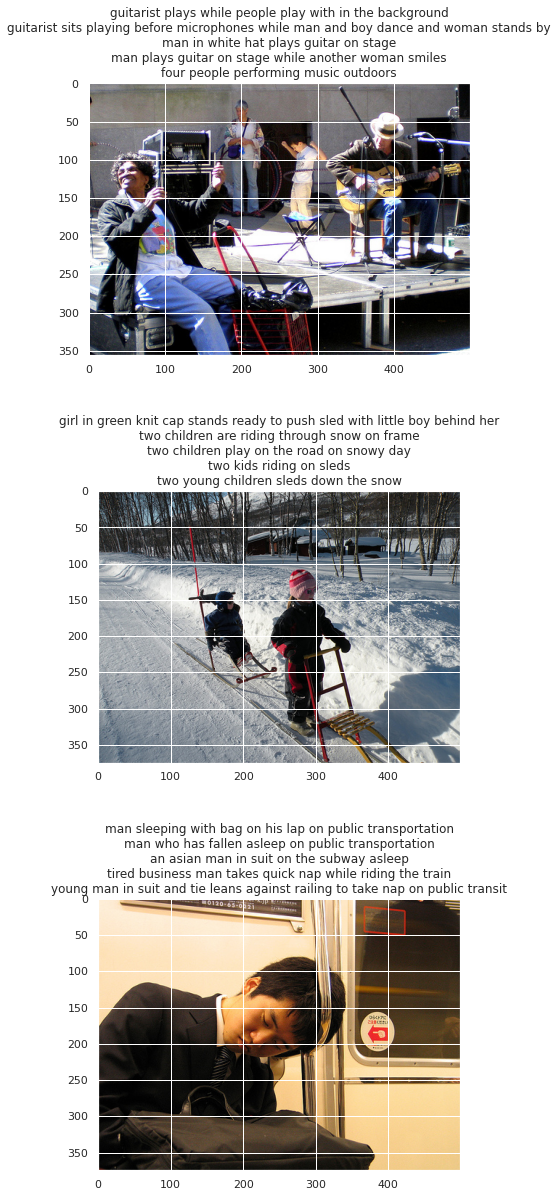

In [ ]:
img_folder = 'Flicker8k_Dataset'

fig = plt.figure( figsize=(30, 35) )

# revisar algunas imágenes

plt.subplots_adjust(wspace=None, hspace=0.5)
idx = 0
for i in range(4):

    file = os.listdir(img_folder)[i] 
    if ( len(file.split('.')) == 3 ):
        continue
    image_path= os.path.join(img_folder, file)
    img= mpimg.imread(image_path)
    ax = fig.add_subplot(5, 1,idx+1)
    ax.title.set_text( '\n'.join(img_text[file.split('.jpg')[0]])) 
    plt.imshow(img)
    idx+=1

### Obtener id's de Train y Validation. 

Por propositos del notebook se reduce la cantidad de ejemplos.
En este dataset dev es validation.

In [ ]:
# load train, dev (validation) y test
'''
Flickr_8k.trainImages.txt - The training images used in our experiments
Flickr_8k.devImages.txt - The development/validation images used in our experiments
Flickr_8k.testImages.txt - The test images used in our experiments
'''
def get_ids(filename):
    ids = []
    with open(filename) as file:
        data = file.readlines()
        for id in data:
            id = id.split('\n')[0]
            ids.append(id)
    return np.array(ids)

train_ids = get_ids('Flickr_8k.trainImages.txt')
val_ids = get_ids('Flickr_8k.devImages.txt')

# para propositos del notebook se reduce la cantidad de ejemplos
np.random.seed(0)
train_idx = np.random.randint(0, train_ids.shape[0], int(train_ids.shape[0]/5))
train_ids = train_ids[train_idx]

train_ids = set(train_ids)
val_ids = set(val_ids)

print("Number of images in train: ", len(train_ids) )

print("Number of images in validation: ", len(val_ids))

Number of images in train:  1086
Number of images in validation:  1000


In [ ]:
# se constuye un nuevo diccionario (key: id imagen, value: captions) 
# que solo va a considerar un subconjunto de id's, por ejemplo, los id's de entrenamiento 
# se aprovecha de agregar tokens <start> and <end> correspondiente al inicio y el final de cada caption.

def get_image_dict(ids):

    captions_dict = {} 
    all_captions = []

    for id in img_text:
        if (id + '.jpg' in ids):
            captions_dict[id] = []
            for caption in  img_text[id]:
                new_caption = '<start> ' + caption + ' <end>'
                all_captions.append(new_caption)

                captions_dict[id].append(new_caption)

    all_captions = np.array(all_captions)
    return captions_dict, all_captions

train_captions, all_train_captions = get_image_dict(train_ids)
val_captions, all_val_captions = get_image_dict(val_ids)


print(len(train_captions))
print(all_train_captions.shape)

print(len(val_captions))
print(all_val_captions.shape) 

1086
(5430,)
1000
(5000,)


### Pre-process images

Hacemos transfer learning para pre-processar las imágenes originales con un modelo pre-entrenado con arquitectura CNN. El modelo en cuestión es Inception v3 de Google, el cual toma las imágenes como input y produce vectores compactos que capturan los features esenciales de la imágen. No hay necesidad de re-entrenar el modelo. 


![](https://miro.medium.com/max/473/0*2Vjcief1IQSfLENi.png)



In [ ]:
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # InceptionV3 trabaja con 299x299

    # utilizando el método preprocess_input para normalizar la imagen de modo que contenga píxeles 
    # en el rango de -1 a 1, que coincide con el formato de las imágenes utilizadas para entrenar InceptionV3
    img = preprocess_input(img)
    return img, image_path
    

# Load Inception-V3 model
model = InceptionV3(weights='imagenet', include_top=False)

# Create new model, by removing last layer (output layer) from Inception-V3
image_features_extract_model = keras.Model(inputs=model.input, outputs=model.layers[-1].output) # outputs=(second last layer output)

image_dir = "Flicker8k_Dataset/"

# agregar el path de las imágenes a cada id
training_image_paths = [image_dir + id for id in train_ids]

# Feel free to change batch_size according to your system configuration

image_dataset = tf.data.Dataset.from_tensor_slices(sorted(set(training_image_paths)))
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 68/68 [05:22<00:00,  4.74s/it]


### Tokenizer

La clase Tokenizer de Keras permite vectorizar un corpus de texto al codificar cada texto (caption) en una secuencia de enteros, donde cada número corresponde al indice del token en el diccionario. 

In [ ]:
from keras.preprocessing.text import Tokenizer


def create_tokenizer(data_dict, all_train_captions):

  max_caption_words = max(len(caption.split()) for caption in all_train_captions) # calcular la máxima cantidad de tokens entre todos los captions.
  
  tokenizer = Tokenizer() # Keras Tokenizer
  
  # Fit en todos los captions
  tokenizer.fit_on_texts(all_train_captions)
  
  vocab_size = len(tokenizer.word_index) + 1 # tamaño del vocabulario

  return (tokenizer, vocab_size, max_caption_words)

# prparar tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(train_captions, all_train_captions)

print("Tamaño del vocabulario: ", vocab_size)
print("Max caption length: ", max_caption_words)

Tamaño del vocabulario:  3198
Max caption length:  28


In [ ]:
# debug
print(tokenizer.word_index['end'])
print(tokenizer.word_index['start'])
print(tokenizer.word_index['dog'])

1
2
8


### Separar Training Data

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# X: image name
# y: secuencias de enteros que corresponden a indices de palabras
def data_prep(data_dict, tokenizer, max_length, vocab_size):
    X, y = list(), list()
    
    for image_name, captions in data_dict.items(): # for cada imagen y lista de captions 
        image_name = image_dir + image_name + '.jpg'
        
        for caption in captions:
            
            # converir el caption en la lista de indices de palabras usando el Tokenizador anterior.
            word_idxs = tokenizer.texts_to_sequences([caption])[0]
            
            # hacer que todas las secuencias tengan el mismo largo (el largo máximo).             
            pad_idxs = (pad_sequences([word_idxs], maxlen=max_length, padding='post')[0])

            X.append(image_name)
            y.append(pad_idxs)
  
    return np.array(X), np.array(y)

train_X, train_y = data_prep(train_captions, tokenizer, max_caption_words, vocab_size)

In [ ]:
# debug
print(train_X[0]) # path de la imagen

# notar que es una secuencia de enteros correspondientes a las palabras del caption.
# el 1 es el token <end> y los 0's rellenan la secuencia para lograr el largo máximo (28 en este caso). 
print(train_y[0])

Flicker8k_Dataset/1001773457_577c3a7d70.jpg
[  2  15   8   7 523   8  14 246   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Mecanismo de Atención

Los datos de entrenamiento se wrapean en un Tensorflow Dataset para ser manipulados de forma eficiente un batch a la vez durante el entrenamiento. 

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# cargar los numpy files con las imágenes (los de antes)
def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

La arquitectura del modelo se describe en los tutoriales de Tensorflow y está inspirada en el artículo Show, Attend and Tell (https://arxiv.org/pdf/1502.03044.pdf), el cual se inspira del articulo original de Bahdanau
(https://arxiv.org/pdf/1409.0473.pdf).


El modelo BahdanauAttention considera 4 componentes:

* **Encoder:** dado que el encoding de las imágenes fue realizado previamente con el modelo Inception, este Encoder es más sencillo: consiste en una capa densa ReLU que toma el vector de features de la imágen y la pasa al Decoder.

* **Sequence Decoder:** es una red recurrente construida con GRU's. Los captions son ingresados como el input despúes de pasar por una Embedding Layer. Una GRU produce una palabra del caption en cada timestep dentro de un train_step considerando: 

>* la palabra verdadera del caption correspondiente al time-step.
>
>* el vector de imagen. 
>
>* el vector de contexto. 
>
>* el estado oculto previo. 

El vector de contexto captura información visual asociada a un localización particular de la imagen input (en la práctica del vector de features de la imagen). 

>En un embedding las palabras se representan por un vector denso, donde cada vector representa una proyección de la palabra en un espacio vectorial continuo.
>Keras ofrece una capa Embedding que puede utilizarse en redes que trabajan sobre textos. 
>
>Requiere que el input sea codificado en enteros, lo cual significa que cada palabra sea representada por un único entero. Esta preparación ya la realizamos con el Tokenizer. La capa Embedding es inicializada con pesos aleatorios y aprenderá un embedding para todas las palabras en el training dataset. 


* **Attention:** a medida que el Decoder genera cada palabra de la secuencia output, el módulo de Attention ayuda a concentrarse en las partes más relevantes de la imagen para generar la palabra. 

* **Sentence Generator:** este módulo consiste en capas lineales. Toma el output del decoder y para cada posición de la secuencia predicha, asigna una probabilidad para cada palabra del vocabulario.

En cada timestep, el Decoder toma el estado oculto del timestep previo y la palabra input actual para producir la palabra output del timestep. Sin atención, el decoder trata todas las partes de la imágen de forma equitativa al generar la palabra output.

Es por esto por lo que el módulo Attention toma la imagen codificada como input junto al estado oculto del Decoder en el timestep previo. Esto produce un Attention Score, que asigna un peso a cada valor de la imagen codificada. Mientras más alto el peso, más relevante es para la palabra a predecir.

![](https://miro.medium.com/max/2400/0*Bnn4FEjOV0hX0XXz.png)

**Nota:** Considerar GRU en vez de LSTM en el diagrama.


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) 
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    # input_dim: This is the size of the vocabulary in the text data. 
    # output_dim: Dimension of the dense embedding.

    self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True, # return or the full sequence, not the last output
                                   return_state=True, # return the last state in addition to the output
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units) # linear activation
    self.fc2 = tf.keras.layers.Dense(vocab_size) # linear activation

    self.attention = BahdanauAttention(self.units)

  # x: decoder input, features: image features, hidden: estado oculto previo
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
import time

embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE # BATCH_SIZE = 64

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()

# SparseCategoricalCrossentropy posee la misma función de loss que categorical_crossentropy
# pero se usa cuando nuestras etiquetas son enteros no one-hot. 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

loss_plot = []
@tf.function
def train_step(img_tensor, target):   # target.shape -> (64, 28)  
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1) # tensor shape -> [64, 1] con el indice de start repetido 64 veces. 

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]): # 28 - 1 timestep (max length)
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing:  
          # is a strategy for training recurrent neural networks that uses ground truth as input (el indice de la palabra verdadera en el time-step)
          # instead of model output from a prior time step as an input.
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

start_epoch = 0
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 10 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch: {epoch+1}, Batch {batch} average Loss: {average_batch_loss:.4f}')
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch: 1, Batch 0 average Loss: 3.1577
Epoch: 1, Batch 10 average Loss: 2.0907
Epoch: 1, Batch 20 average Loss: 1.9731
Epoch: 1, Batch 30 average Loss: 2.1368
Epoch: 1, Batch 40 average Loss: 2.1710
Epoch: 1, Batch 50 average Loss: 2.0962
Epoch: 1, Batch 60 average Loss: 1.8258
Epoch: 1, Batch 70 average Loss: 1.9244
Epoch: 1, Batch 80 average Loss: 1.7768
Epoch 1 Loss 2.100832
Time taken for 1 epoch 362.87 sec

Epoch: 2, Batch 0 average Loss: 2.0034
Epoch: 2, Batch 10 average Loss: 1.7613
Epoch: 2, Batch 20 average Loss: 1.8389
Epoch: 2, Batch 30 average Loss: 1.6242
Epoch: 2, Batch 40 average Loss: 1.5718
Epoch: 2, Batch 50 average Loss: 1.8103
Epoch: 2, Batch 60 average Loss: 1.7646
Epoch: 2, Batch 70 average Loss: 1.7025
Epoch: 2, Batch 80 average Loss: 1.5575
Epoch 2 Loss 1.730105
Time taken for 1 epoch 284.38 sec

Epoch: 3, Batch 0 average Loss: 1.6321
Epoch: 3, Batch 10 average Loss: 1.5716
Epoch: 3, Batch 20 average Loss: 1.5269
Epoch: 3, Batch 30 average Loss: 1.4599
Epoch: 3,

In [ ]:
# debug
'''
for (batch, (img_tensor, target)) in enumerate(dataset):
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1) 
    print(target.shape)
    print(a)
    for i in range(1, target.shape[1]):
        dec_input = tf.expand_dims(target[:, i], 1)
        print(dec_input)

    break
'''
print()

Loss v/s Epoch

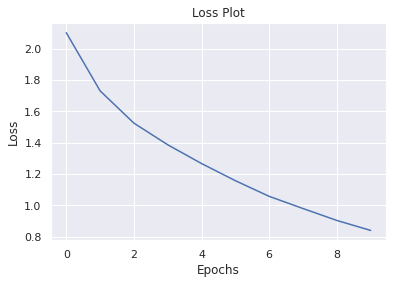

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluación

Image name:  1131155939_b4b457b05e


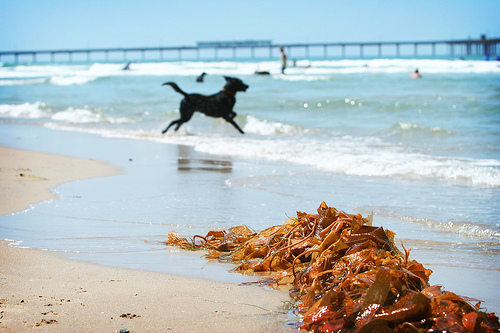

Real Caption:
<start> black dog runs into the ocean next to pile of seaweed <end>
<start> black lav runs into the water on the beach with swimmers in the distance and sea kelp in the foreground <end>
<start> dog at the shore of an ocean with seaweed in foreground <end>
<start> dog is running in the waves at the beach <end>
<start> pile of seaweed sits on the sand behind it big black dog is running in the water <end>

Prediction Caption: black dog with blue collar is playing in the water

(28, 64)


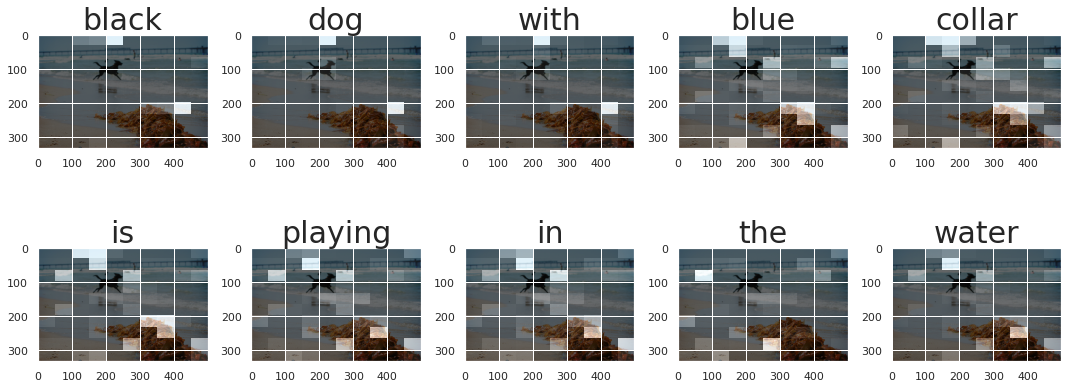

In [ ]:
from IPython.display import Image, display

def plot_attention(image, result, attention_plot):
    print(attention_plot.shape)
    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    
    grid_size = max(np.ceil(len_result/2), 2)

    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (10,10))
        
        
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i], fontsize = 30)
        
        img = mpimg.imread(image)
        img = ax.imshow(img)

        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        tf.random.set_seed(0)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'end':
            return result[:-1], attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot
  
def check_test(image_dict, image_dir, max_caption_words, id = -1):
    
    names = list(image_dict.keys())
    # random validation caption
    if (id == -1):
        id = np.random.randint(0, len(names))
    
    image_name = names[id]
    
    print("Image name: ", image_name)

    real_caption = image_dict[image_name]   
    
    image_path = image_dir + image_name + '.jpg'
    
    result, attention_plot = evaluate(image_path, max_caption_words)    
    
    display(Image(image_path))
    print('Real Caption:')
    [print(rc) for rc in real_caption]
    
    print('\nPrediction Caption:', ' '.join(result))

    print()
    plot_attention(image_path, result, attention_plot)


image_dir = "Flicker8k_Dataset/"


i = 15 # 15, 40
check_test(val_captions, image_dir, max_caption_words, i)

Más experimentos

Image name:  1131155939_b4b457b05e


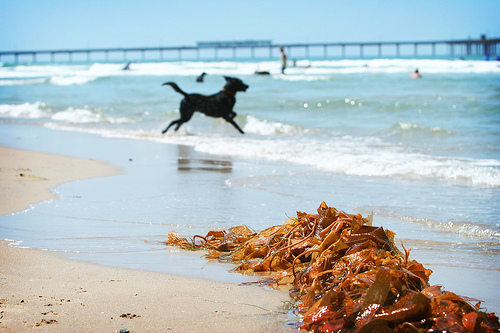

Real Caption:
<start> black dog runs into the ocean next to pile of seaweed <end>
<start> black lav runs into the water on the beach with swimmers in the distance and sea kelp in the foreground <end>
<start> dog at the shore of an ocean with seaweed in foreground <end>
<start> dog is running in the waves at the beach <end>
<start> pile of seaweed sits on the sand behind it big black dog is running in the water <end>

Prediction Caption: black dog with blue collar is playing in the water

(28, 64)


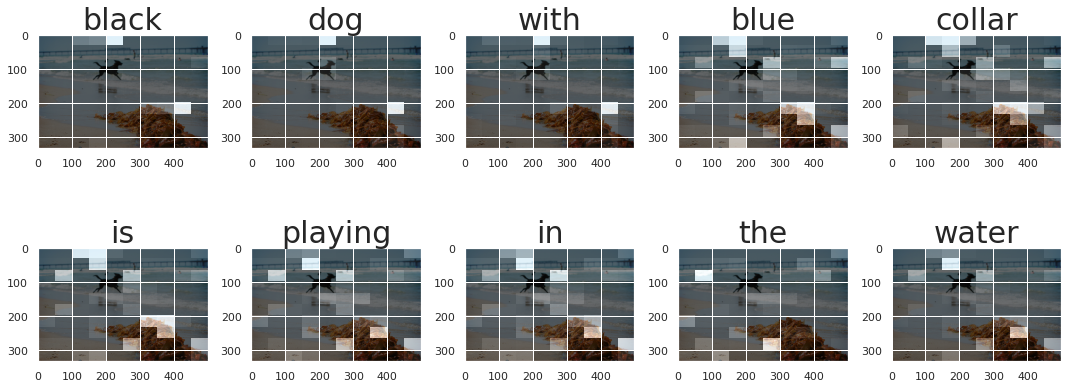

Image name:  1332823164_c70a5d930e


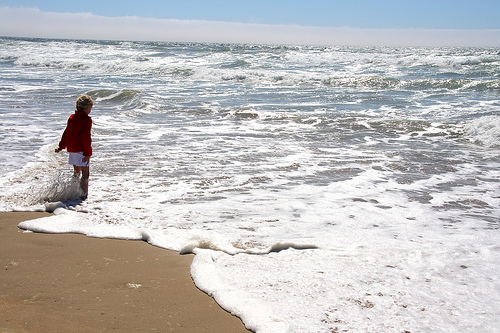

Real Caption:
<start> girl standing in the ocean <end>
<start> girl walks in the ocean <end>
<start> woman in red jacket stands on the beach facing the water as it covers her feet <end>
<start> woman is watching the tide <end>
<start> woman standing on the shore of beach <end>

Prediction Caption: man is running on the beach

(28, 64)


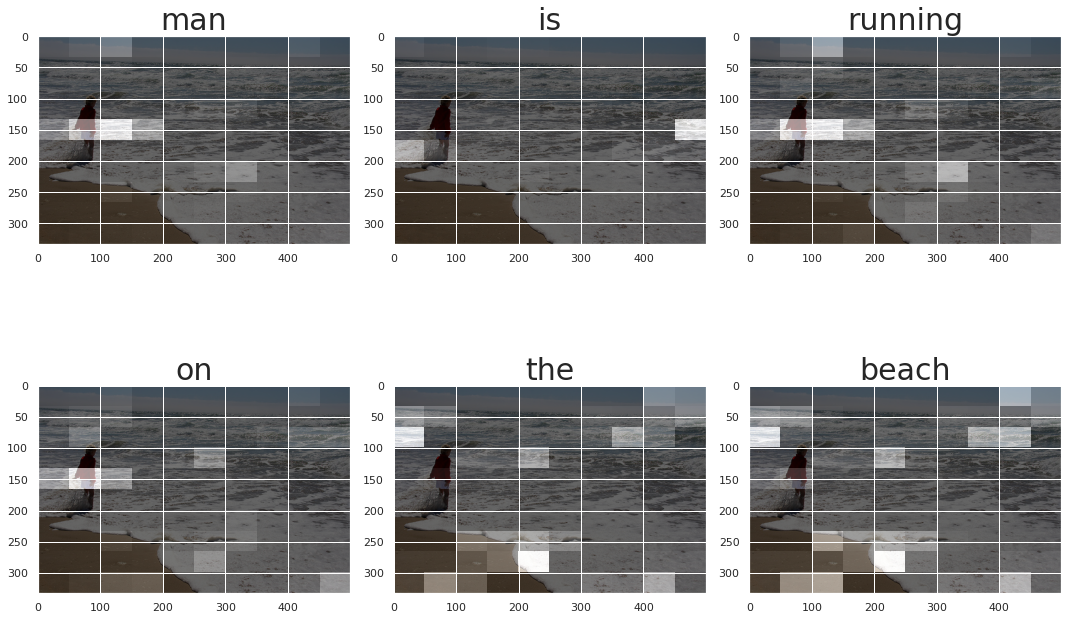

Image name:  1388970365_162edcceb4


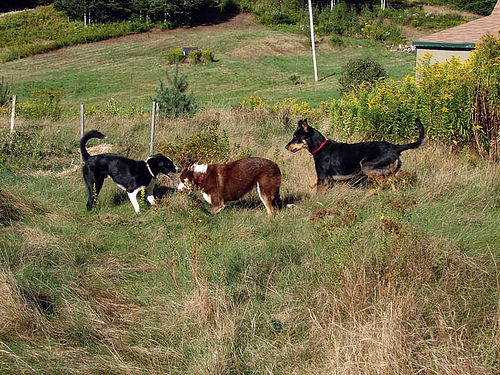

Real Caption:
<start> brown dog and two black dogs in an overgrown grassy field <end>
<start> three dogs in field looking at something in the grass <end>
<start> three dogs play in field near house to the right <end>
<start> three dogs two black one brown are playing in grass field <end>
<start> two black dogs and one brown dog in tall grass <end>

Prediction Caption: black and black and black and black and black and black and black and black and black and black and black and black and black and black and

(28, 64)


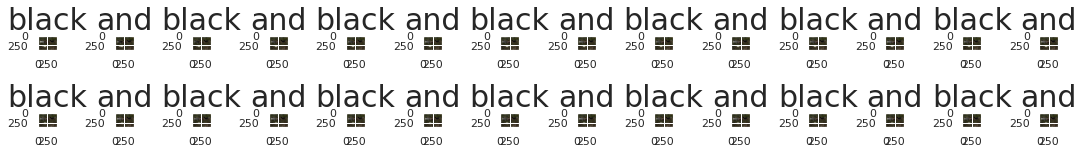

Image name:  2891162278_fbf96be4f4


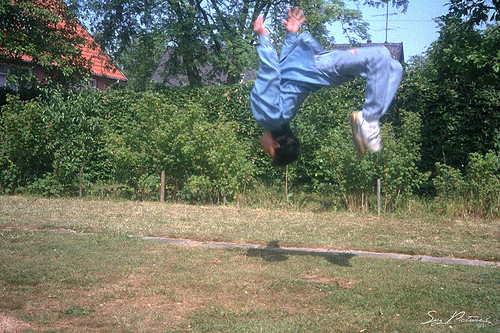

Real Caption:
<start> boy in blue shirt is doing back flip in the air <end>
<start> man in jean jacket and jean pants is doing back flip on grassy area <end>
<start> person dressed in blue performing back flip <end>
<start> person dressed in light blue with white shoes does back flip in the grass <end>
<start> person doing backflips outside in the grass <end>

Prediction Caption: boy is holding her bench

(28, 64)


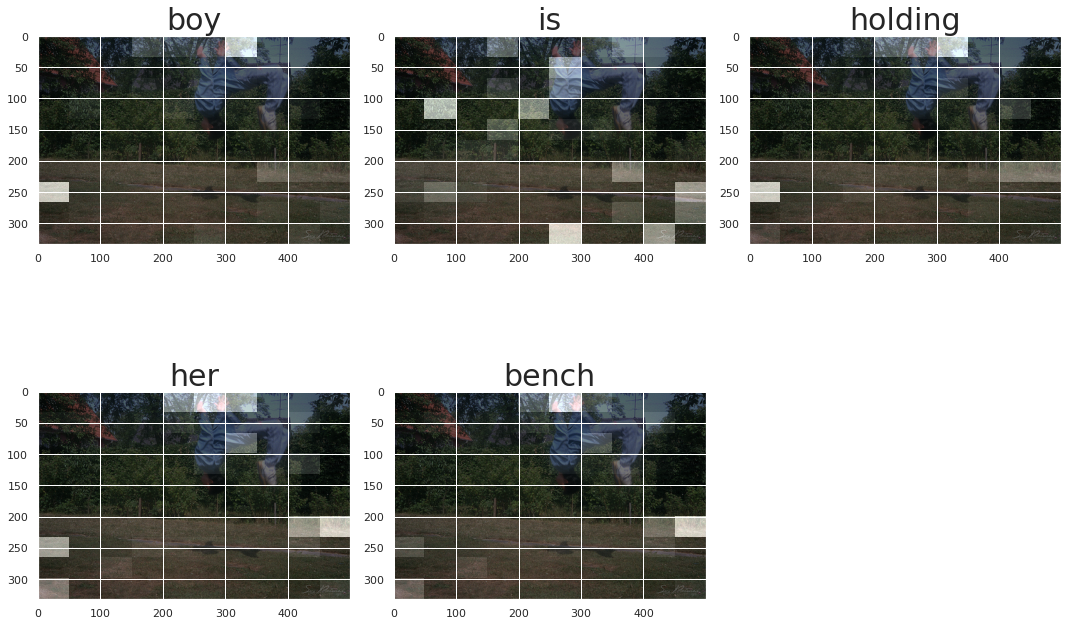

Image name:  2902486045_6298eb22ef


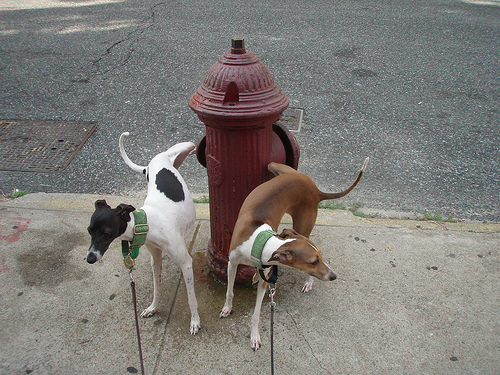

Real Caption:
<start> two dogs are peeing at red fire hydrant <end>
<start> two dogs are urinating on the red fire hydrant <end>
<start> two dogs peeing on fire hydrant <end>
<start> two dogs pee on the fire hydrant <end>
<start> two dogs urinating on red fire hydrant <end>

Prediction Caption: dog is jumping for the beach

(28, 64)


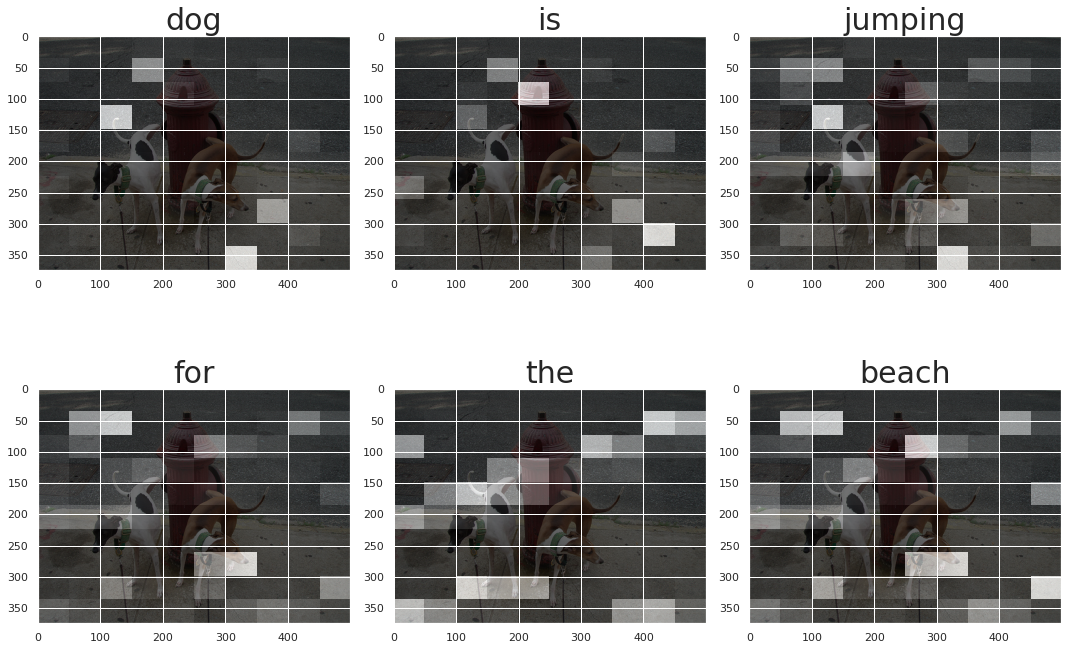

Image name:  3439243433_d5f3508612


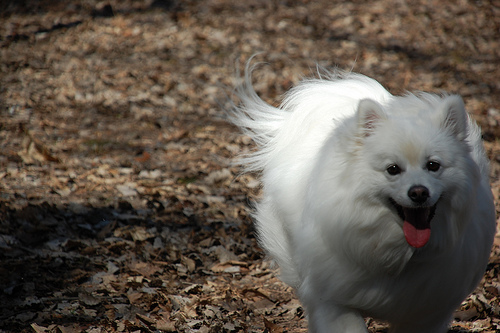

Real Caption:
<start> long haired white dog is in an area covered with fallen brown leaves <end>
<start> white dog standing on fallen leaves <end>
<start> white dog standing on leaves on the ground <end>
<start> white furry dog is running through leaves <end>
<start> white furry dog is walking on leaves with its tongue sticking out <end>

Prediction Caption: dog is jumping to its mouth

(28, 64)


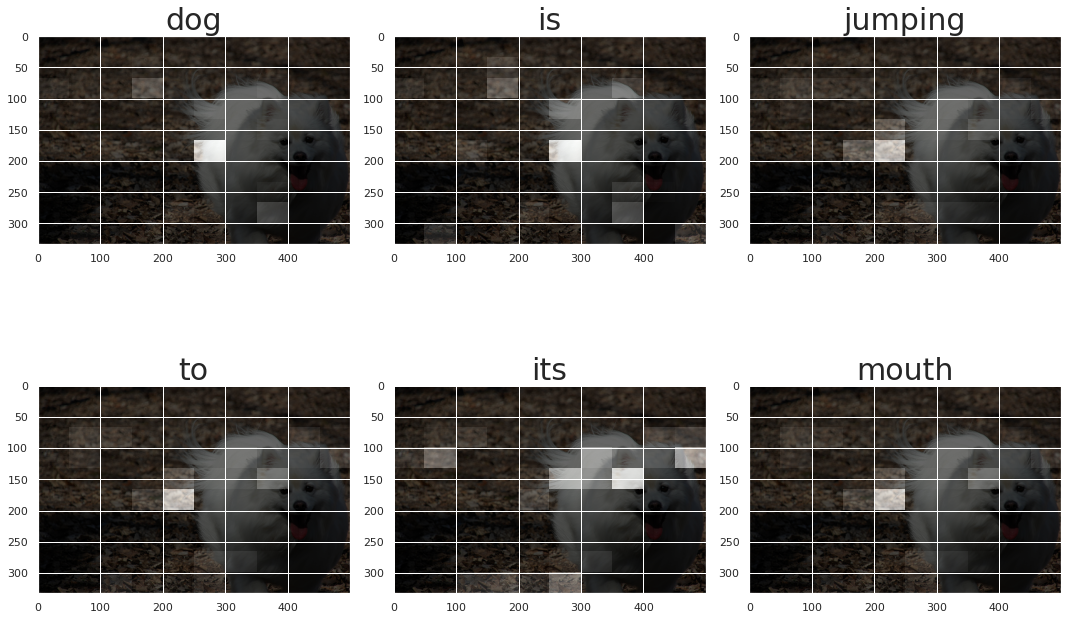

Image name:  3563461991_de05537878


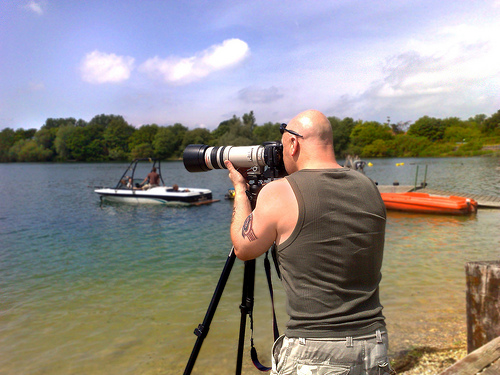

Real Caption:
<start> bald man is taking shots of body of water from camera <end>
<start> man is taking photos with long range lens by body of water <end>
<start> man takes photos on the water edge <end>
<start> man wearing tank top loooking into camera that on tripod <end>
<start> muscular man taking pictures of lake with boats <end>

Prediction Caption: two young girl in front of some video camera

(28, 64)


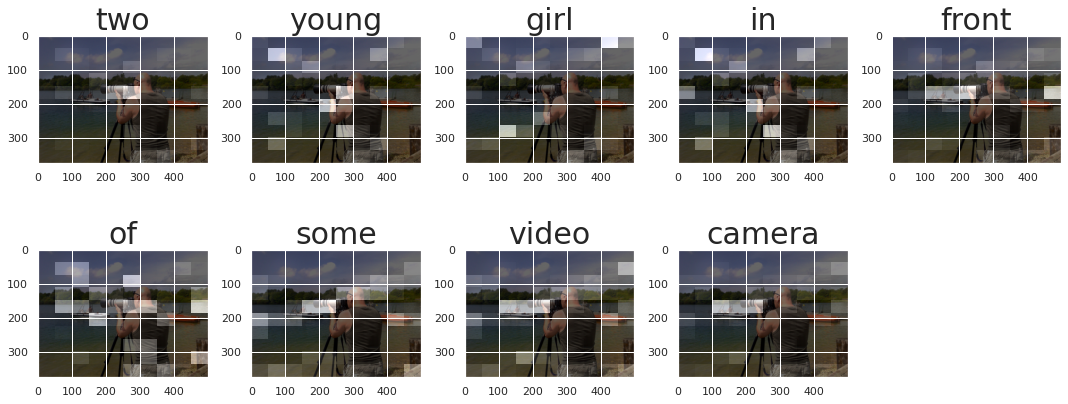

Image name:  619169586_0a13ee7c21


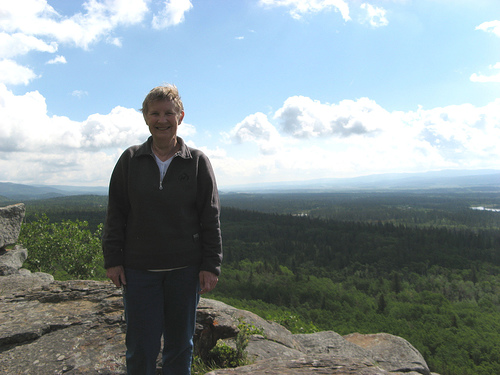

Real Caption:
<start> woman in brown jacket is standing on rock with forested background <end>
<start> woman posing near cliff <end>
<start> woman standing in front of trees and smiling <end>
<start> woman stands on mountain overlooking rolling field of trees underneath blue sky <end>
<start> the person poses for picture on cliff overlooking valley <end>

Prediction Caption: man is jumping over the ocean

(28, 64)


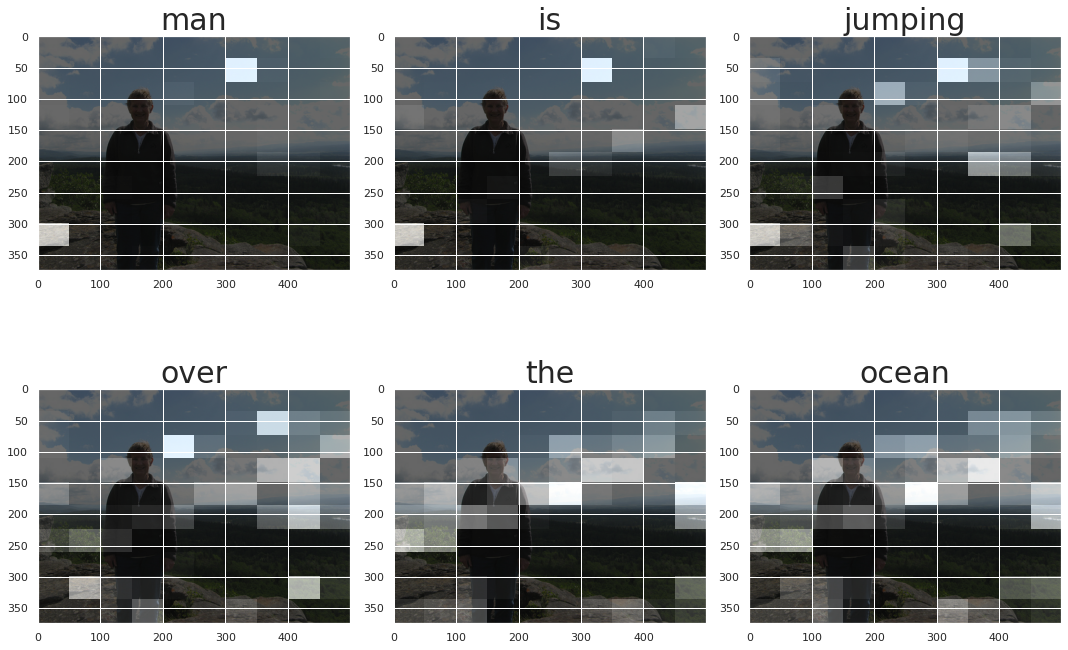

Image name:  3381161854_af8b05243c


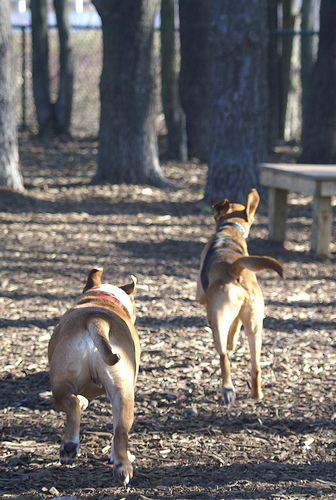

Real Caption:
<start> two dogs are running up woodland path <end>
<start> two dogs run across the woods <end>
<start> two dogs running toward trees <end>
<start> two dogs run on path near stone bench <end>
<start> two short dogs run away from the camera in the trees <end>

Prediction Caption: dog is sitting on to fighting while by brown grass

(28, 64)


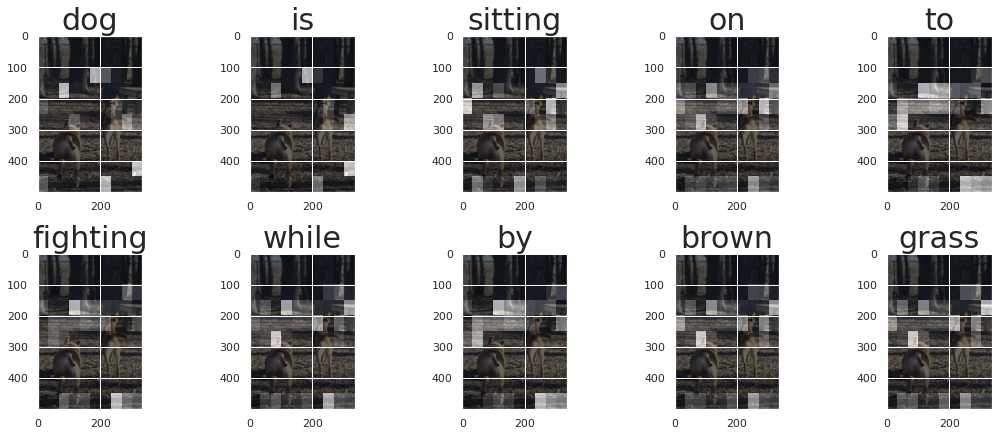

Image name:  3594566537_55bd712fdb


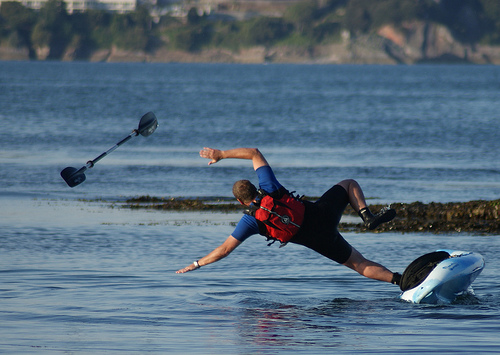

Real Caption:
<start> man falls out of his kayak <end>
<start> man is falling out of his kayak as his paddles go flying <end>
<start> man kayaking losing his paddle and falling out of the boat <end>
<start> the man falls into the water while his paddle flies and his kayak tips <end>
<start> the man threw his paddle in the air and fell out of the boat and into the water <end>

Prediction Caption: man in blue bathing suit is jumping over the background

(28, 64)


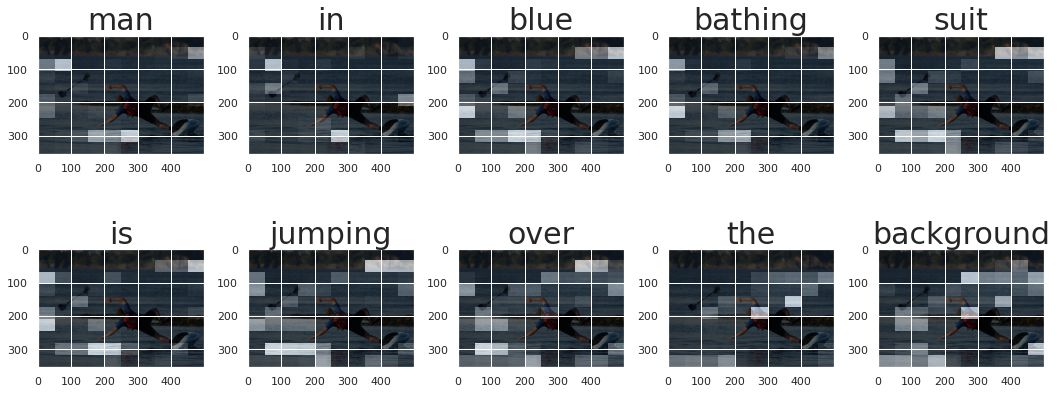

In [ ]:
# mas pruebas

for i in [15, 30, 41, 393, 400, 700, 800, 960, 654, 816]:
    check_test(val_captions, image_dir, max_caption_words, i)